<a href="https://colab.research.google.com/github/nand0san/notebooks/blob/master/historical_candles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import requests
import csv

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
symbol = 'BTCUSDT'
tick_interval = '1d'

In [0]:
def get_candles(start='', symbol='BTCUSDT', tick_interval='1d', limit=1000):
    
    base_url = 'https://api.binance.com/'
    endpoint = 'api/v3/klines?'
    
    if start:
        query = 'symbol=' + symbol + '&interval=' + tick_interval + '&startTime=' + str(start) +'&limit='+str(limit)
    else:
        query = 'symbol=' + symbol + '&interval=' + tick_interval +'&limit='+str(limit)
        
    candles = requests.get(base_url + endpoint + query).json()
    
    return candles, candles[-1][6]  # return candles and last colse time in a tuple

In [0]:
def get_all_candles_from_start(symbol, tick_interval):  # devuelve una lista de velas, cada vela es una lista tb
    
    start=1502942400000  # 17 de agosto de 2017
    _, last_time = get_candles(start='', symbol=symbol , tick_interval=tick_interval, limit=1)
    
    candles = []
    while start < last_time:
        i_candles, next_hop = get_candles(start, symbol, tick_interval)
        candles = candles + i_candles
        start = next_hop
        
    return candles

In [0]:
candles = get_all_candles_from_start(symbol, tick_interval)
columns=['open_time','open', 'high', 'low','close','volume','close_time','quote','trades',
         'takers_buy_base','takers_buy_quote','ignore']
df = pd.DataFrame(candles, columns=columns)

In [43]:
df = df.sort_values('close_time')
df.drop_duplicates(keep='last')
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027 entries, 0 to 1026
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open_time         1027 non-null   float64
 1   open              1027 non-null   float64
 2   high              1027 non-null   float64
 3   low               1027 non-null   float64
 4   close             1027 non-null   float64
 5   volume            1027 non-null   float64
 6   close_time        1027 non-null   float64
 7   quote             1027 non-null   float64
 8   trades            1027 non-null   float64
 9   takers_buy_base   1027 non-null   float64
 10  takers_buy_quote  1027 non-null   float64
 11  ignore            1027 non-null   float64
dtypes: float64(12)
memory usage: 104.3 KB


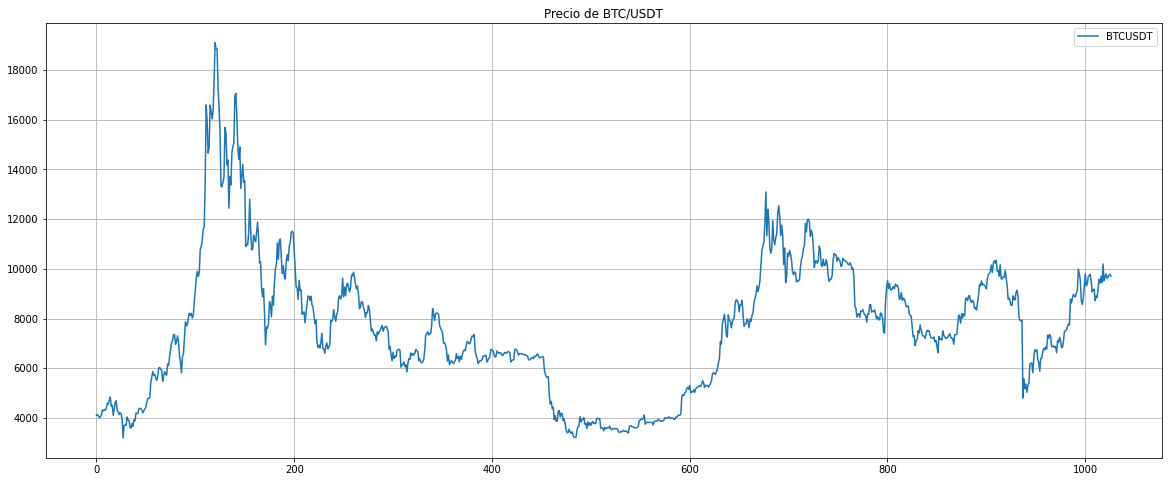

In [44]:
df['close'].plot(figsize=(20,8), label='BTCUSDT')
plt.title('Precio de BTC/USDT')
plt.legend()
plt.grid()

In [45]:
df

,open_time,open,high,low,close,volume,close_time,quote,trades,takers_buy_base,takers_buy_quote,ignore
0,1.503014e+12,4285.08,4371.52,3938.77,4108.37,1199.888264,1.503101e+12,5.086958e+06,5233.0,972.868710,4.129123e+06,9384.141409
1,1.503101e+12,4108.37,4184.69,3850.00,4139.98,381.309763,1.503187e+12,1.549484e+06,2153.0,274.336042,1.118002e+06,9184.085529
2,1.503187e+12,4120.98,4211.08,4032.62,4086.29,467.083022,1.503274e+12,1.930364e+06,2321.0,376.795947,1.557401e+06,10125.414084
3,1.503274e+12,4069.13,4119.62,3911.79,4016.00,691.743060,1.503360e+12,2.797232e+06,3972.0,557.356107,2.255663e+06,11706.769970
4,1.503360e+12,4016.00,4104.82,3400.00,4040.00,966.684858,1.503446e+12,3.752506e+06,6494.0,423.995181,1.637188e+06,11773.279500
...,...,...,...,...,...,...,...,...,...,...,...,...
1022,1.591315e+12,9788.14,9854.75,9581.00,9621.16,47788.050050,1.591402e+12,4.652008e+08,566062.0,22329.107119,2.174445e+08,0.000000
1023,1.591402e+12,9621.17,9735.00,9531.05,9666.30,32752.950893,1.591488e+12,3.156049e+08,435796.0,15832.693765,1.526108e+08,0.000000
1024,1.591488e+12,9666.85,9802.00,9372.46,9746.99,57952.848385,1.591574e+12,5.569196e+08,637766.0,28426.595129,2.732429e+08,0.000000
1025,1.591574e+12,9746.99,9800.00,9633.00,9782.01,40664.664125,1.591661e+12,3.954594e+08,485139.0,19744.039124,1.920380e+08,0.000000


In [0]:
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df['close_time'] = df['close_time'].dt.tz_localize('utc').dt.tz_convert('Europe/Madrid')
df = df.set_index('close_time')

In [0]:
df.drop('ignore', axis=1, inplace=True)

In [48]:
df

,open_time,open,high,low,close,volume,quote,trades,takers_buy_base,takers_buy_quote
close_time,,,,,,,,,,
2017-08-19 01:59:59.999000+02:00,1.503014e+12,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233.0,972.868710,4.129123e+06
2017-08-20 01:59:59.999000+02:00,1.503101e+12,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153.0,274.336042,1.118002e+06
2017-08-21 01:59:59.999000+02:00,1.503187e+12,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321.0,376.795947,1.557401e+06
2017-08-22 01:59:59.999000+02:00,1.503274e+12,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972.0,557.356107,2.255663e+06
2017-08-23 01:59:59.999000+02:00,1.503360e+12,4016.00,4104.82,3400.00,4040.00,966.684858,3.752506e+06,6494.0,423.995181,1.637188e+06
...,...,...,...,...,...,...,...,...,...,...
2020-06-06 01:59:59.999000+02:00,1.591315e+12,9788.14,9854.75,9581.00,9621.16,47788.050050,4.652008e+08,566062.0,22329.107119,2.174445e+08
2020-06-07 01:59:59.999000+02:00,1.591402e+12,9621.17,9735.00,9531.05,9666.30,32752.950893,3.156049e+08,435796.0,15832.693765,1.526108e+08
2020-06-08 01:59:59.999000+02:00,1.591488e+12,9666.85,9802.00,9372.46,9746.99,57952.848385,5.569196e+08,637766.0,28426.595129,2.732429e+08


In [0]:
df.to_csv(f'{symbol}_{tick_interval}.csv',index=False,header=True, quoting=csv.QUOTE_ALL)

In [50]:
!ls

BTCUSDT_1d.csv	sample_data


In [0]:
from google.colab import files
files.download('BTCUSDT_1d.csv')

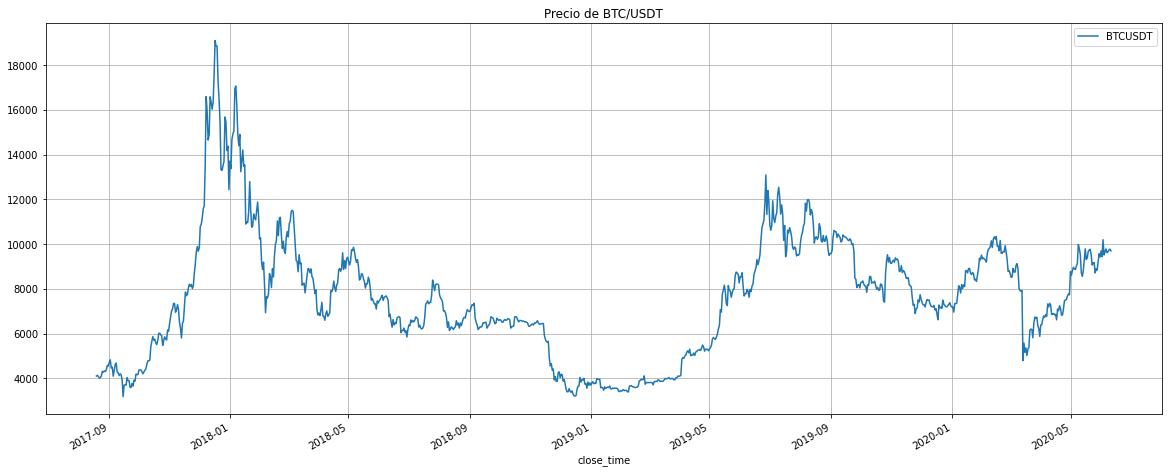

In [52]:
df['close'].plot(figsize=(20,8), label='BTCUSDT')
plt.title('Precio de BTC/USDT')
plt.legend()
plt.grid()